              precision    recall  f1-score   support

        -1.0       0.84      0.87      0.86       102
         1.0       0.86      0.83      0.84        98

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



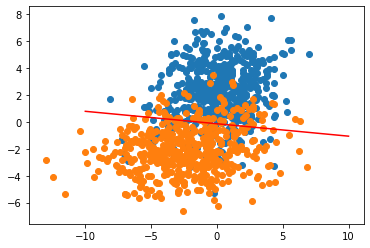

In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

n_samples = 500

def gen_gaussian(mean_in, cov_in, class_label):
    nv = multivariate_normal(mean = mean_in, cov = cov_in)
    X = nv.rvs(n_samples)
    y = np.ones(n_samples, dtype=float) * class_label
    return nv,X,y

mu1, sigma1 = [0, 2], [[5, 1], [1, 5]]
mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
nv2, X2, y2 = gen_gaussian(mu2, sigma2, -1) # negative class

# join the posisitve and negative class clusters
X = np.vstack((X1, X2))
y = np.hstack((y1, y2))

# shuffle the data
perm = list(range(0,n_samples*2))
shuffle(perm)
X = X[perm]
y = y[perm]

plt.scatter(X1[:,0], X1[:,1], label="pos")
plt.scatter(X2[:,0], X2[:,1], label="neg")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred))


params = svclassifier.coef_
a = params[0][0]
b = params[0][1]
c = svclassifier.intercept_

x = np.linspace(-10,10,100)
y = (-a*x - c) / b
plt.plot(x, y, '-r', label='Boundary')
plt.show()


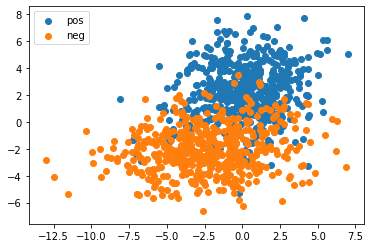

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination
n_samples = 500

def gen_gaussian(mean_in, cov_in, class_label):
    nv = multivariate_normal(mean = mean_in, cov = cov_in)
    X = nv.rvs(n_samples)
    y = np.ones(n_samples, dtype=float) * class_label
    return nv,X,y

mu1, sigma1 = [0, 2], [[5, 1], [1, 5]]
mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
nv2, X2, y2 = gen_gaussian(mu2, sigma2, -1) # negative class

# join the posisitve and negative class clusters
X = np.vstack((X1, X2))
y = np.hstack((y1, y2))

# shuffle the data
perm = list(range(0,n_samples*2))
shuffle(perm)
X = X[perm]
y = y[perm]

rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
X_aux = np.dot(X, rotation_mult)


""" Generate the sensitive feature here """
x_control = [] # this array holds the sensitive feature value
for i in range (0, len(X)):
    x = X_aux[i]

    # probability for each cluster that the point belongs to it
    p1 = nv1.pdf(x)
    p2 = nv2.pdf(x)

    # normalize the probabilities from 0 to 1
    s = p1+p2
    p1 = p1/s
    p2 = p2/s

    r = np.random.uniform() # generate a random number from 0 to 1

    if r < p1: # the first cluster is the positive class
        x_control.append(1.0) # 1.0 means its male
    else:
        x_control.append(0.0) # 0.0 -> female

x_control = np.array(x_control)
# x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary

plt.scatter(X1[:,0], X1[:,1], label="pos")
plt.scatter(X2[:,0], X2[:,1], label="neg")
plt.legend()
plt.show()

In [59]:
import numpy as np


def add_intercept(x):

    """ Add intercept to the data before linear classification """
    m,n = x.shape
    print('Add intercept ..', m , '  n :  ', n)
    intercept = np.ones(m).reshape(m, 1) # the constant b
    return np.concatenate((intercept, x), axis = 1)

X = add_intercept(X)


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, x_control_train, x_control_test = train_test_split(X, y,x_control, test_size = 0.20)






Add intercept .. 1000   n :   2


In [87]:
from scipy.optimize import minimize # for loss func minimization

max_iter = 100000 # maximum number of iterations for the minimization algorithm



def get_correlations(model, x_test, y_predicted, x_control_test, sensitive_attrs):
    

    """
    returns the fraction in positive class for sensitive feature values
    """

    if model is not None:
        y_predicted = np.sign(np.dot(x_test, model))
        
    y_predicted = np.array(y_predicted)
    
    out_dict = {}
    for attr in sensitive_attrs:

        attr_val = []
        for v in x_control_test[attr]: attr_val.append(v)
        assert(len(attr_val) == len(y_predicted))


        total_per_val = defaultdict(int)
        attr_to_class_labels_dict = defaultdict(lambda: defaultdict(int))

        for i in range(0, len(y_predicted)):
            val = attr_val[i]
            label = y_predicted[i]

            # val = attr_val_int_mapping_dict_reversed[val] # change values from intgers to actual names
            total_per_val[val] += 1
            attr_to_class_labels_dict[val][label] += 1

        class_labels = set(y_predicted.tolist())

        local_dict_1 = {}
        for k1,v1 in attr_to_class_labels_dict.items():
            total_this_val = total_per_val[k1]

            local_dict_2 = {}
            for k2 in class_labels: # the order should be the same for printing
                v2 = v1[k2]

                f = float(v2) * 100.0 / float(total_this_val)


                local_dict_2[k2] = f
            local_dict_1[k1] = local_dict_2
        out_dict[attr] = local_dict_1

    return out_dict




def check_accuracy(model, x_train, y_train, x_test, y_test, y_train_predicted, y_test_predicted):

    if model is not None:
        y_test_predicted = np.sign(np.dot(x_test, model))
        y_train_predicted = np.sign(np.dot(x_train, model))

    def get_accuracy(y, Y_predicted):
        correct_answers = (Y_predicted == y).astype(int) # will have 1 when the prediction and the actual label match
        accuracy = float(sum(correct_answers)) / float(len(correct_answers))
        return accuracy, sum(correct_answers)

    train_score, correct_answers_train = get_accuracy(y_train, y_train_predicted)
    test_score, correct_answers_test = get_accuracy(y_test, y_test_predicted)

    return train_score, test_score, correct_answers_train, correct_answers_test



def log_logistic(X):
    if X.ndim > 1: raise Exception("Array of samples cannot be more than 1-D!")
    out = np.empty_like(X) # same dimensions and data types

    idx = X>0
    out[idx] = -np.log(1.0 + np.exp(-X[idx]))
    out[~idx] = X[~idx] - np.log(1.0 + np.exp(X[~idx]))
    return out



def _logistic_loss(w, X, y, return_arr=None):

    yz = y * np.dot(X,w)
    # Logistic loss is the negative of the log of the logistic function.
    if return_arr == True:
        out = -(log_logistic(yz))
    else:
        out = -np.sum(log_logistic(yz))
    return out


def train_model(x, y, x_control, loss_function):
    f_args=(x, y)
    w = minimize(fun = loss_function,
        x0 = np.random.rand(x.shape[1],),
        args = f_args,
        method = 'SLSQP',
        options = {"maxiter":max_iter},
        constraints = []
        )
    
    return w


def get_line_coordinates(w, x1, x2):
    y1 = (-w[0] - (w[1] * x1)) / w[2]
    y2 = (-w[0] - (w[1] * x2)) / w[2]    
    return y1,y2


In [88]:
loss_function = _logistic_loss
w = train_model(x_train, y_train, x_control_train, loss_function)

try:
    assert(w.success == True)
    print(w.x)
except:
    print('no')

[0.23438898 0.10696521 0.96607316]


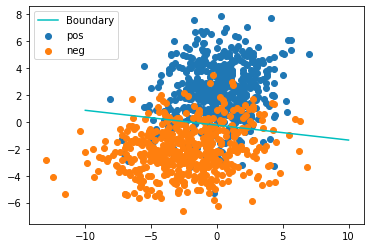

In [89]:
plt.scatter(X1[:,0], X1[:,1], label="pos")
plt.scatter(X2[:,0], X2[:,1], label="neg")

params = w.x
a = params[1]
b = params[2]
c = params[0]

x = np.linspace(-10,10,100)
y = (-a*x - c)/ b
plt.plot(x, y, '-c', label='Boundary')


plt.legend()
plt.show()


In [95]:
w = params
train_score, test_score, correct_answers_train, correct_answers_test = check_accuracy(w, x_train, y_train, x_test, y_test, None, None)

print('train_Score', train_score)
print('test_score',test_score)

distances_boundary_test = (np.dot(x_test, w)).tolist()
all_class_labels_assigned_test = np.sign(distances_boundary_test)   

correlation_dict_test = get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)


train_Score 0.855
test_score 0.86
[-1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.
 -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.
  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.
  1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1.  1. -1.
  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.
  1. -1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1. -1.
 -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1.
 -1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1.
  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.
 -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.
 -1. -1.]
